# Dublin Bikes Data Analysis

In [2]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [3]:
# Combine the dataframe together into one
data1 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20190701_20191001.csv')
data3 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20191001_20200101.csv')
data4 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200101_20200401.csv')
data5 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200401_20200701.csv')
data6 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200701_20201001.csv')
data7 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210101_20210401.csv')
data8 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210401_20210701.csv')
data9 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210701_20211001.csv')

#merge data into one table
data = pd.concat([data1, data2, data3, data4,data5,data6,data7,data8,data9])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24417920 entries, 0 to 2858176
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   STATION ID             int64  
 1   TIME                   object 
 2   LAST UPDATED           object 
 3   NAME                   object 
 4   BIKE STANDS            int64  
 5   AVAILABLE BIKE STANDS  int64  
 6   AVAILABLE BIKES        int64  
 7   STATUS                 object 
 8   ADDRESS                object 
 9   LATITUDE               float64
 10  LONGITUDE              float64
dtypes: float64(2), int64(4), object(5)
memory usage: 2.2+ GB


In [7]:
data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,2,2019-04-01 00:00:06,2019-03-31 23:52:05,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
1,2,2019-04-01 00:05:04,2019-04-01 00:02:13,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
2,2,2019-04-01 00:10:04,2019-04-01 00:02:13,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
3,2,2019-04-01 00:15:03,2019-04-01 00:12:21,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
4,2,2019-04-01 00:20:03,2019-04-01 00:12:21,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
...,...,...,...,...,...,...,...,...,...,...,...
2858172,117,2021-10-01 23:35:02,2021-10-01 23:27:46,HANOVER QUAY EAST,40,35,5,Open,Hanover Quay East,53.343655,-6.231755
2858173,117,2021-10-01 23:40:02,2021-10-01 23:37:53,HANOVER QUAY EAST,40,35,5,Open,Hanover Quay East,53.343655,-6.231755
2858174,117,2021-10-01 23:45:03,2021-10-01 23:37:53,HANOVER QUAY EAST,40,35,5,Open,Hanover Quay East,53.343655,-6.231755
2858175,117,2021-10-01 23:50:04,2021-10-01 23:47:59,HANOVER QUAY EAST,40,35,5,Open,Hanover Quay East,53.343655,-6.231755


In [5]:
data['LAST UPDATED']=data['LAST UPDATED'].astype(str)

In [8]:
data['TIME']=data['TIME'].astype(str)

In [24]:
#merge data into one table
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2021-10-01')]
#data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)



KeyboardInterrupt: 

In [28]:
data['YEAR'] = data['DATETIME'].dt.year

In [43]:
def C19(x):
    if x > 2019:
        return 0
    else:
        return 0
data["COVID_INDICATOR"] = data['YEAR'].apply(C19)

In [10]:
### Prepare Weather Data

weather = pd.read_csv('hly175.csv')
weather['date'] = [dt.datetime.strptime(d, "%m/%d/%Y %H:%M") for d in weather['date'] ]
weather['date_for_merge'] = weather['date'].dt.round('H')
weather = weather[(weather['date'] >= '2019-04-01') & (weather['date'] < '2020-04-02')]
weather = weather[['date_for_merge', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]
weather['rain'] = weather['rain'].astype(float)
weather['temp'] = weather['temp'].astype(float)

#add binary variables to note wet/dry weather and hot or not days (temperature)
weather['dry'] = np.where(weather['rain'] > 0.0, 1, 0)
weather['warm'] = np.where(weather['temp'] > 18.0, 1, 0)
weather.sample(5)


,date_for_merge,rain,temp,wetb,dewpt,vappr,rhum,msl,dry,warm
118464,2020-03-23 01:00:00,0.0,0.4,-0.2,-1.4,5.5,87,1024.5,0,0
116990,2020-01-21 15:00:00,0.0,7.9,7.5,7.0,10.0,93,1041.5,0,0
115493,2019-11-20 06:00:00,0.2,9.4,9.0,8.6,11.2,95,1002.5,1,0
115239,2019-11-09 16:00:00,0.0,6.0,4.7,2.9,7.5,80,1002.7,0,0
111222,2019-05-26 07:00:00,0.0,14.7,13.7,12.8,14.8,88,1011.6,0,0


In [44]:
#merge weather with bikes data
merged_data = pd.merge(data,weather, on ='date_for_merge', how = 'left')

In [45]:
# identify bike arrivals and bike departures
merged_data['BIKE_ARR_DEP'] = merged_data.groupby('STATION ID')['AVAILABLE BIKE STANDS'].diff(-1)
merged_data['BIKE_ARR'] = np.where(merged_data['BIKE_ARR_DEP'] > 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['BIKE_DEP'] = np.where(merged_data['BIKE_ARR_DEP'] < 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['ACTIVITY_TYPE'] = np.where(abs(merged_data['BIKE_ARR_DEP']) >= 10, "REBALANCING", "RENTAL")
merged_data['IMBALANCED'] = np.where(merged_data['OCCUPANCY_PCT'] < .1, 1, 
                                   np.where(merged_data['OCCUPANCY_PCT'] > .9, 1,0 ))

In [46]:
# Identify days with rebalancing
merged_data['REBALANCING'] = np.where(merged_data['ACTIVITY_TYPE'] == 'REBALANCING', 1,0)
merged_data['JOIN_ON'] = merged_data['STATION ID'].apply(str)  + (merged_data['DATE']).apply(str) 
join_table= merged_data.groupby(['JOIN_ON'])['REBALANCING'].sum()
merged_data = merged_data.drop(['REBALANCING'], axis = 1)
join_table = join_table.to_frame()
join_table =join_table.reset_index()
merged_data = pd.merge(merged_data, join_table, on = 'JOIN_ON', how = 'left')
merged_data = merged_data.drop(['JOIN_ON'], axis = 1)

merged_data.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,rhum,msl,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING
3453772,3,13:46:31,BOLTON STREET,20,16,4,Open,Bolton Street,53.351181,-6.269859,...,83,1030.0,0.0,0.0,0.0,0.0,0.0,RENTAL,0,0
6760779,108,11:24:10,AVONDALE ROAD,40,35,5,Open,Avondale Road,53.359406,-6.276142,...,NaN,NaN,NaN,NaN,2.0,2.0,0.0,RENTAL,0,0
6322196,92,00:13:02,HEUSTON BRIDGE (NORTH),40,16,24,Open,Heuston Bridge (North),53.347801,-6.292432,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,RENTAL,0,0
12234408,85,23:18:16,ROTHE ABBEY,35,17,18,Open,Rothe Abbey,53.338776,-6.303950,...,NaN,NaN,NaN,NaN,1.0,1.0,0.0,RENTAL,0,1
11779243,31,08:58:06,PARNELL STREET,20,1,19,Open,Parnell Street,53.350929,-6.265125,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,RENTAL,1,1


### Time Clusters

In [47]:
#group data into clusters
clustering_df = merged_data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP','YEAR','COVID_INDICATOR']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(5)

CLUSTER_GROUP,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday
NAME,,,,,,,,,,,,,,,,,,
SIR PATRICK DUN'S,58,53.339218,-6.240642,0.384684,0.447936,0.540595,0.369446,0.429676,0.318029,0.396309,0.454302,0.497169,0.377700,0.437544,0.299830,0.327928,0.397913,0.319337
PHIBSBOROUGH ROAD,110,53.356308,-6.273717,0.271308,0.223209,0.221673,0.238644,0.194626,0.240911,0.266752,0.227993,0.219936,0.222822,0.202772,0.312205,0.270687,0.218015,0.299852
AVONDALE ROAD,108,53.359406,-6.276142,0.199160,0.192271,0.198189,0.215533,0.217695,0.268799,0.264628,0.206821,0.209533,0.237808,0.269773,0.346255,0.339077,0.264663,0.371663
PARNELL STREET,31,53.350929,-6.265125,0.672356,0.639656,0.458567,0.519656,0.474742,0.453443,0.545526,0.452875,0.378291,0.356872,0.339252,0.326618,0.461343,0.349415,0.318791
CATHAL BRUGHA STREET,24,53.352150,-6.260533,0.687155,0.598115,0.417616,0.593802,0.505984,0.537987,0.648820,0.578756,0.372260,0.499050,0.326170,0.468375,0.543754,0.434384,0.355041


### K-Means Clustering Analysis

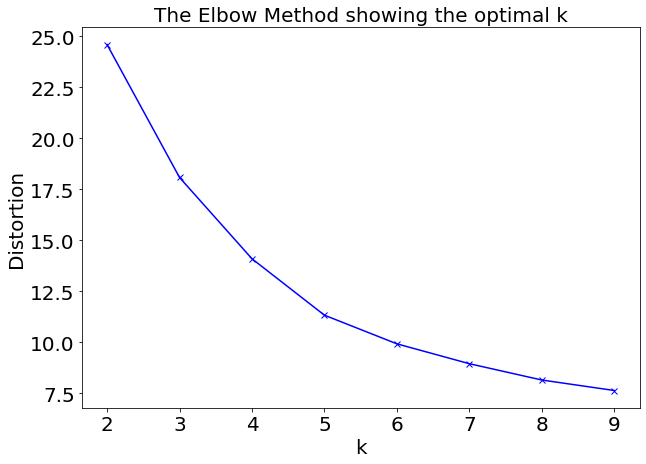

In [48]:
distortions = []
K = range(2,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

CLUSTER_GROUP,NAME,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.199160,0.192271,0.198189,0.215533,0.217695,0.268799,0.264628,0.206821,0.209533,0.237808,0.269773,0.346255,0.339077,0.264663,0.371663,1
1,BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751,3
2,BENSON STREET,90,53.344154,-6.233451,0.220124,0.227388,0.482751,0.233156,0.269470,0.230001,0.246937,0.256477,0.506306,0.258984,0.303515,0.196983,0.204867,0.260693,0.209208,1
3,BLACKHALL PLACE,88,53.348801,-6.281637,0.421198,0.453738,0.297745,0.500456,0.492530,0.460481,0.541389,0.588214,0.398933,0.590841,0.614548,0.689094,0.673697,0.652818,0.743176,4
4,BLESSINGTON STREET,2,53.356770,-6.268140,0.231873,0.206871,0.223172,0.230224,0.262427,0.270180,0.244195,0.237608,0.225054,0.296462,0.339703,0.428828,0.413801,0.358214,0.472987,0


In [50]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
    

In [51]:
#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['STATION ID', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
del merged_data
merged_with_clusters = pd.merge (merged_with_clusters, cluster_output, on = 'STATION ID', how = 'left')
merged_with_clusters['BIKE_ARR_DEP_ABS'] = abs(merged_with_clusters['BIKE_ARR_DEP'])
merged_with_clusters.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING,Cluster,BIKE_ARR_DEP_ABS
10114746,27,22:39:01,MOLESWORTH STREET,20,20,0,Open,Molesworth Street,53.341290,-6.258117,...,NaN,NaN,0.0,0.0,0.0,RENTAL,1,1,2.0,0.0
7527581,102,09:15:53,WESTERN WAY,40,34,6,Open,Western Way,53.354931,-6.269425,...,NaN,NaN,0.0,0.0,0.0,RENTAL,0,1,1.0,0.0
10496291,15,19:58:44,HARDWICKE STREET,16,6,10,Open,Hardwicke Street,53.355473,-6.264423,...,NaN,NaN,0.0,0.0,0.0,RENTAL,0,0,1.0,0.0
2800156,111,14:38:48,MOUNTJOY SQUARE EAST,40,40,0,Open,Mountjoy Square East,53.356716,-6.256359,...,0.0,0.0,1.0,1.0,0.0,RENTAL,1,0,0.0,1.0
5479389,66,20:30:11,NEW CENTRAL BANK,40,12,28,Open,New Central Bank,53.347122,-6.234749,...,NaN,NaN,0.0,0.0,0.0,RENTAL,0,0,3.0,0.0


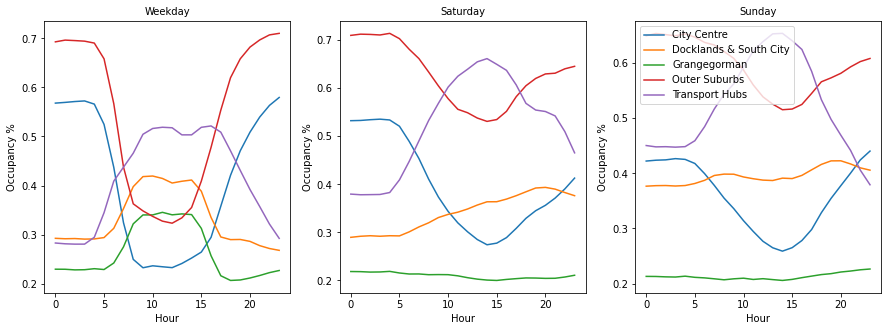

In [52]:
linechart_data = merged_with_clusters[['DAY_TYPE', 'Cluster', 'HOUR', 'OCCUPANCY_PCT']]
linechart_data['Cluster'] = np.where(linechart_data['Cluster'] == 0, 'City Centre',
                                    np.where(linechart_data['Cluster'] == 1, 'Grangegorman',
                                            np.where(linechart_data['Cluster'] == 2, 'Transport Hubs',
                                                    np.where(linechart_data['Cluster'] == 3, 'Docklands & South City', 'Outer Suburbs'))))

#Weekday
linechart_data_weekday = linechart_data[linechart_data['DAY_TYPE'] == 'Weekday']
linechart_data_weekday = linechart_data_weekday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_weekday  = linechart_data_weekday.reset_index()
y1 = linechart_data_weekday['OCCUPANCY_PCT'].values
x1 = linechart_data_weekday['HOUR'].values
labels1 = linechart_data_weekday['Cluster'].values
colours1 = linechart_data_weekday['Cluster'].values
df1 = pd.DataFrame(dict(x=x1, y=y1, label=labels1))
groups1 = df1.groupby('label')

#Saturday
linechart_data_saturday = linechart_data[linechart_data['DAY_TYPE'] == 'Saturday']
linechart_data_saturday = linechart_data_saturday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_saturday  = linechart_data_saturday.reset_index()
y2 = linechart_data_saturday['OCCUPANCY_PCT'].values
x2 = linechart_data_saturday['HOUR'].values
labels2 = linechart_data_saturday['Cluster'].values
colours2 = linechart_data_saturday['Cluster'].values
df2 = pd.DataFrame(dict(x=x2, y=y2, label=labels2))
groups2 = df2.groupby('label')

#Sunday
linechart_data_sunday = linechart_data[linechart_data['DAY_TYPE'] == 'Sunday']
linechart_data_sunday = linechart_data_sunday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_sunday  = linechart_data_sunday.reset_index()
y3 = linechart_data_sunday['OCCUPANCY_PCT'].values
x3 = linechart_data_sunday['HOUR'].values
labels3 = linechart_data_sunday['Cluster'].values
colours3 = linechart_data_sunday['Cluster'].values
df3 = pd.DataFrame(dict(x=x3, y=y3, label=labels3))
groups3 = df3.groupby('label')

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for name, group in groups1:
    axs[0].plot(group.x, group.y, label=name)
    axs[0].set_title('Weekday')
    axs[0].set_xlabel('Hour')
    axs[0].set_ylabel('Occupancy %')
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

for name, group in groups2:
    axs[1].plot(group.x, group.y, label=name)
    axs[1].set_title('Saturday')
    axs[1].set_xlabel('Hour')
    axs[1].set_ylabel('Occupancy %')
    

for name, group in groups3:
    axs[2].plot(group.x, group.y, label=name)
    axs[2].set_title('Sunday')
    axs[2].set_xlabel('Hour')
    axs[2].set_ylabel('Occupancy %')
    axs[2].legend()

plt.show()

In [53]:
# Impact of Stations
join_table= merged_with_clusters.groupby(['STATION ID','NAME', 'DATE']).agg(rain=('rain', 'sum'), TOTAL_CHANGES=('BIKE_ARR_DEP_ABS', 'sum'))
join_table =join_table.reset_index()
join_table['WET/DRY DAY'] = np.where(join_table['rain'] > 3, "Wet", "Dry")
join_table = join_table.drop(['rain'], axis = 1)
join_table =join_table.reset_index()
merged_with_clusters_wetdry = pd.merge(merged_with_clusters, join_table, on = ['STATION ID', 'NAME', 'DATE'], how = 'left')

wetday_df= merged_with_clusters_wetdry.groupby(['STATION ID', 'NAME', 'WET/DRY DAY']).agg(AVG_CHANGES=('TOTAL_CHANGES', 'mean'))
wetday_df =wetday_df.reset_index()
difference_df = wetday_df.pivot(index=['NAME'], columns='WET/DRY DAY', values='AVG_CHANGES').reset_index()
difference_df['Change'] = difference_df['Dry'] - difference_df['Wet']
difference_df.sort_values(by = 'Change', ascending=False).head(30)

WET/DRY DAY,NAME,Dry,Wet,Change
6,BROADSTONE,25.133185,11.240880,13.892305
31,FOWNES STREET UPPER,221.512694,212.893946,8.618748
1,BARROW STREET,210.558365,209.820408,0.737957
39,GRANGEGORMAN LOWER (NORTH),20.084065,22.565999,-2.481934
89,PHIBSBOROUGH ROAD,55.950084,58.641486,-2.691401
0,AVONDALE ROAD,50.255406,56.053769,-5.798363
38,GRANGEGORMAN LOWER (CENTRAL),15.556244,21.492633,-5.936390
63,KILMAINHAM GAOL,75.201409,82.958139,-7.756729
107,UPPER SHERRARD STREET,117.665919,126.356558,-8.690639
74,MOUNT BROWN,33.440400,42.397568,-8.957168


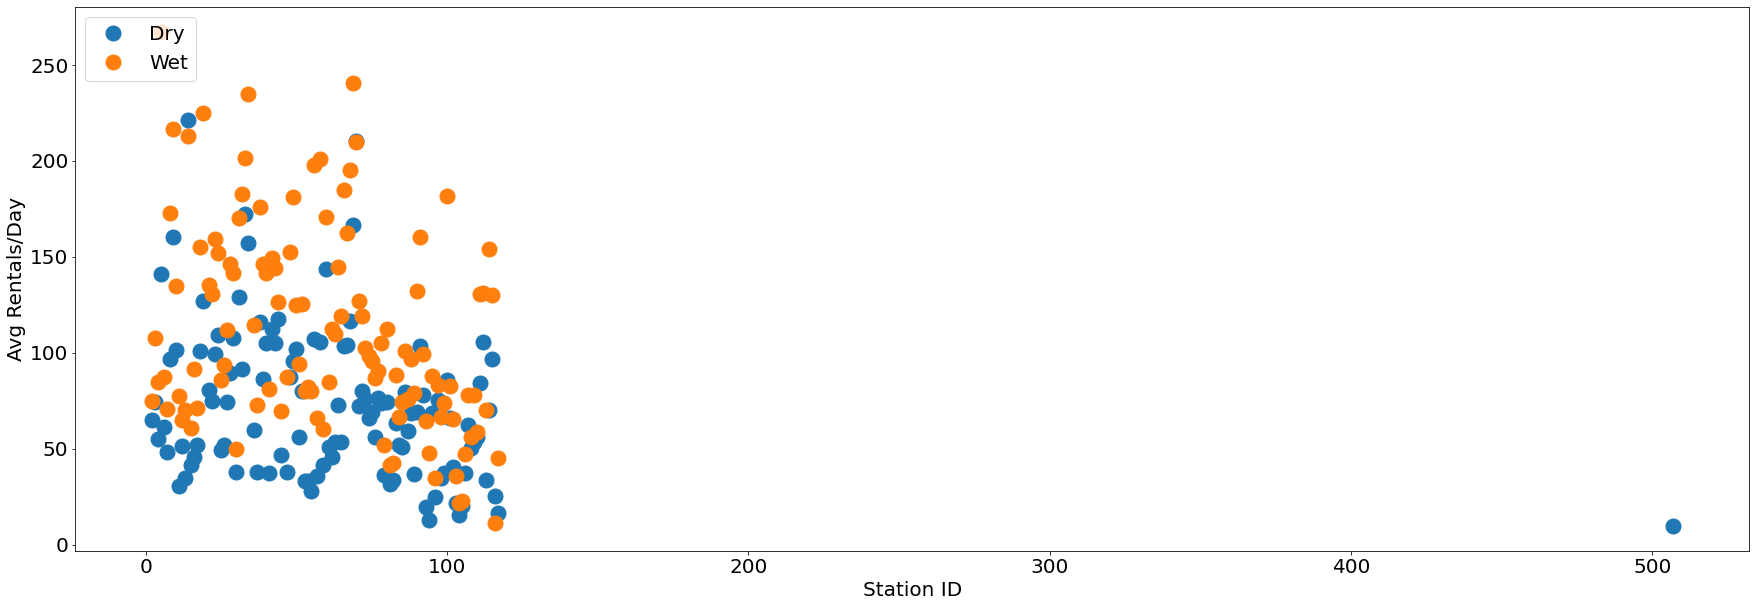

In [54]:
import pandas as pd
y = wetday_df['AVG_CHANGES'].values
x = wetday_df['STATION ID'].values
labels = wetday_df['WET/DRY DAY'].values
colours = wetday_df['WET/DRY DAY'].values
df = pd.DataFrame(dict(x=x, y=y, label=labels))
groups = df.groupby('label')

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y,  marker='o',  linestyle='', ms=15, label=name)
ax.legend(numpoints=1, loc='upper left')
plt.xlabel("Station ID")
plt.ylabel("Avg Rentals/Day")
plt.show()

### ML Occupancy Percentage Classifier

In [55]:
ml_classifier_data = merged_with_clusters[merged_with_clusters['REBALANCING'] < 1] #exclude days where rebalancing took place
ml_classifier_data = ml_classifier_data[['STATION ID', 'OCCUPANCY_PCT' , 'dry', 'warm', 'DAY_NUMBER', 'HOUR', 'MONTH','YEAR','COVID_INDICATOR']]


def bin_occupancy(x):
    if x < 0.1:
        return 0
    elif x < 0.1:
        return 0.1
    elif x < 0.2:
        return 0.1
    elif x < 0.3:
        return 0.1
    elif x < 0.4:
        return 0.1
    elif x < 0.5:
        return 0.1
    elif x < 0.6:
        return 0.1
    elif x < 0.7:
        return 0.1
    elif x < 0.8:
        return 0.1
    else:
        return 0.2

ml_classifier_data["OCC_GROUP"] = ml_classifier_data['OCCUPANCY_PCT'].apply(bin_occupancy)
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"] * 10
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"].astype(int)
ml_classifier_data.dropna(inplace = True)
msk = np.random.rand(len(ml_classifier_data)) < 0.8
train = ml_classifier_data[msk]
test = ml_classifier_data[~msk]
print(len(train))
print(len(test))

X_train = train.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
X_test = test.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
Y_train = train[["OCC_GROUP"]] 
Y_test = test[["OCC_GROUP"]]

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

Y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

#pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
print(sklearn.metrics.classification_report(Y_test,Y_pred))

2769585
693354
Accuracy: 0.7907403721619837
              precision    recall  f1-score   support

           0       0.78      0.72      0.75    190299
           1       0.80      0.85      0.82    393189
           2       0.77      0.71      0.74    109866

    accuracy                           0.79    693354
   macro avg       0.78      0.76      0.77    693354
weighted avg       0.79      0.79      0.79    693354



No handles with labels found to put in legend.


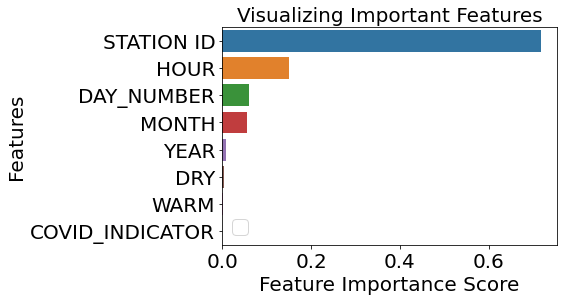

In [56]:
## show feature importances 

feature_imp = pd.Series(clf.feature_importances_,index=['STATION ID','DRY', 'WARM', 'DAY_NUMBER', 'HOUR', 'MONTH','YEAR','COVID_INDICATOR']).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()